# HW 5 - Page Rank
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In Weeks 8 and 9 you discussed key concepts related to graph based algorithms including SSSP.   
In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia.
By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

__Please refer to the `README` for homework submission instructions and additional resources.__ 

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [9]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [10]:
%reload_ext autoreload
%autoreload 2

In [11]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [30]:
# start Spark Session
# Added for Extra Credit pt. 2
import os
PACKAGES = ['graphframes:graphframes:0.7.0-spark2.3-s_2.11']
os.environ['PYSPARK_SUBMIT_ARGS'] = f"--packages {','.join(PACKAGES)} pyspark-shell"
print(os.environ['PYSPARK_SUBMIT_ARGS'])

from pyspark.sql import SparkSession
app_name = "hw5_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

--packages graphframes:graphframes:0.7.0-spark2.3-s_2.11 pyspark-shell


__`REMINDER`__: If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 


### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) short response:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm?

* __c) short response:__ Briefly describe Dijskra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:
> __a)__ One example is a dataset for the social media application Twitter where users would be nodes and follows would be edges.  This graph would be directed since user1 can follow user2 without user2 needing to follow user1.  The average in-degree of a node would represent the average number of followers that a given user will have in this example.

> __b)__ Graphs are unique in that they require maintaining partial, or full, records of the graph in memory during the MapReduce job.  It is challenging to work within this constraint as there are many ways to represent a graph (e.g. Adjacency Matrix, List, etc), and passing this object between Mappers and Reducers requires complex keys.  Many of the graph based algorithms we have learned also rely on data structures which are difficult to parallelize as well, such as the Priority Queue.  

> __c)__ Dijstra's algorithm is used to determine the shortest path from a single node in a graph.  The idea behind this algorithm is to iterate over all nodes using a priority queue to keep track of which nodes to visit next based on their distance from the source node.  During each iteratio, the algorithm expands the shortest distance node and updates the distance to any reachable nodes.  The difficulty in parallelizing this approach is in its reliance on a global priority queue data structure which can't be read/written to with multiple nodes in the MapReduce framework.  

> __d)__ Parallel breadth-first-search does not utilize a global priority queue.  It uses a FIFO (Frontier) queue to keep track of which nodes should be processed/expanded next and which ones have already been visited.   The algorithm maps over all nodes to create key-value pairs for each neighbor on the node’s adjacency list, then reduces by selecting the shortest distance and updating the distance in the node data structure.  This algorithm requires multiple iterations (additional MapReduce jobs) in order to compute the shortest distance to all nodes.  Since this is a brute force algorithm, it spends time recomputing previously determined distances which is computationally wasteful compared to Dijkstra's algorithm.  

# Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="Lin-Dyer-graph-Q1.png" width="70%">

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.


### Q2 Student Answers:
> __a)__ In general, the Twitter followers graph would be extremely sparse as most users will not be following most other users.  A typical user likely will only follow a small fraction of the N users available in the network.  As the graph becomes more dense for an adjacency matrix, there will be fewer points which are zero due to no edge (e.g. follow) being present.  As the graph becomes more dense for an adjacency list, there will be more values added to each node (e.g. user) in the list.  In other words, the adjacency list is more space efficient as the graph becomes more sparse.  

> __b)__ This graph is directed as noted by the unidirectional arrows for each edge.  The primary difference between the two graph's matrices will be the symetry of the elements along the main diagonal.  The adjacency matrix for a directed graph will have be non-symetric across the matrix's main diagonal while the adjacency matrix for an undirected graph will be symetrical across the matrix's main diagonal.  Arguably, an undirected graph can be represented as only the bottom or top half of the graph since no more information is kept by keeping the entire graph.  



In [5]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

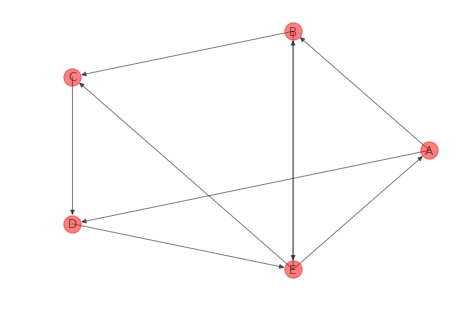

In [6]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5)

In [26]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################

    for edge in graph['edges']:
        adj_matr.at[edge[0], edge[1]] = 1
    
    ############### (END) YOUR CODE #################
    return adj_matr

In [27]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

   A  B  C  D  E
A  0  1  0  1  0
B  0  0  1  0  1
C  0  0  0  1  0
D  0  0  0  0  1
E  1  1  1  0  0


In [50]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    
    for node in graph['nodes']:
        for edge in graph['edges']:
            # Check edge is for current node
            if edge[0] == node:
                adj_list[node].append(edge[1])
    
    ############### (END) YOUR CODE #################
    return adj_list

In [51]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}


# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q3 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) short response:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) short response:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) code + short response:__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) code + short response:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. How many iterations does it take to converge? Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.
    
    
    
### The Power Method Algorithm
```
initial approximation - random unit vector x0
# xInit = np.random.rand(transition_matrix.shape[1])
x1=Ax0
x2=AAx0=A2x0
x3=AAAx0=A3x0
...
until converges
```
For large powers of k, we will obrain a good approximation of the dominant eigenvector  
http://mlwiki.org/index.php/Power_Iteration

### Q3 Student Answers:
> __a)__ In the random walk/surfer example, the PageRank metric for each node measures the visit rate over an extended period of time (i.e. ad infinitum).  The sum of PageRank metrics for all nodes should sum to 1 as they represent probabilities.  More generally, PageRank is a probability distribution over graph nodes representing the likelihood that a random walk over the graph will arrive at a particular node.

> __b)__ The Markov Property is present when the next state depends only one the current state, and has no reliance on any previous states (e.g. stateless).  In PageRank, it means that the random surfer/walker should be able to move to the next node without any need to reference their past traversed nodes.

> __c)__ The n states are in the random walk over the WebGraph example represent a website that the user is currently visiting.  The relation between the n states (i.e. websites) and the size of the transition matrix is squared since the transition matrix's size is n x n, or n^2.  

> __d)__ A right stochastic matrix is a real non-negative valued square matrix where each row's values sum to 1.

> __e)__ Per Kyle's comment https://ucbischool.slack.com/archives/GF5U13U4C/p1561892917017500, skipping implementation but answered the short response questions.  The most central, or highest ranked, node is E.  This makes sense since E has 3 websites it links to and 2 websites linking to it.  

In [52]:
# part d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [86]:
# part d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################

transition_matrix = np.divide(TOY_ADJ_MATR, TOY_ADJ_MATR.sum(axis=1)[:, None])

################ (END) YOUR CODE #################
print(transition_matrix)

          A         B         C    D    E
A  0.000000  0.500000  0.000000  0.5  0.0
B  0.000000  0.000000  0.500000  0.0  0.5
C  0.000000  0.000000  0.000000  1.0  0.0
D  0.000000  0.000000  0.000000  0.0  1.0
E  0.333333  0.333333  0.333333  0.0  0.0


In [148]:
# part e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    
    # Note, using power_iteration2 method from 2 cells below with small modifications
    b_k = xInit

    for ix in range(nIter):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(np.transpose(tMatrix), b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm
        if verbose:
            print(f'Step {ix}:\n {b_k}')
                
    state_vector = b_k
    
    ################ (END) YOUR CODE #################
    return state_vector

In [133]:
def eigenvalue(A, v):
    Av = A.dot(v)
    return v.dot(Av)

def power_iteration1(A):
    n, d = A.shape

    v = np.ones(d) / np.sqrt(d)
    ev = eigenvalue(A, v)
    count = 0
    
    while True:
        count += 1
        Av = A.dot(v)
        v_new = Av / np.linalg.norm(Av)

        ev_new = eigenvalue(A, v_new)
        
        if np.abs(ev - ev_new) < 0.00001:
            break
        
        v = v_new
        ev = ev_new

    return ev_new, v_new, count

In [134]:
power_iteration1(np.transpose(transition_matrix))

(1.0000153302911787, A    0.221536
 B    0.332321
 C    0.387697
 D    0.498490
 E    0.664593
 dtype: float64, 24)

In [135]:
#!/usr/bin/python

import numpy as np

def power_iteration2(A, num_simulations):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    # b_k = np.array([1.0, 0, 0, 0, 0])
    b_k = np.random.rand(A.shape[1])

    for ix in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(np.transpose(A), b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)
        # re normalize the vector
        b_k = b_k1 / b_k1_norm


        #print(f'Step {ix}:\n {b_k}')
    return b_k

power_iteration2(transition_matrix, 100)

array([0.22153951, 0.33230927, 0.38769414, 0.4984639 , 0.66461853])

In [136]:
#transition_matrix
#[[0, 0.5, 0, 0.5, 0],[0, 0, 0.5, 0, 0.5],[0, 0, 0, 1, 0],[0, 0, 0, 0, 1],[0.33333333, 0.33333333, 0.33333333, 0, 0]]

In [138]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
xInit = np.random.rand(transition_matrix.shape[1])
xInit = np.ones(transition_matrix.shape[1]) / np.sqrt(transition_matrix.shape[1])
xInit = np.ones(transition_matrix.shape[1]) / (transition_matrix.shape[1])
print(xInit)
states = power_iteration(xInit, transition_matrix, 10, False)
print(states)
print("---")
print(np.transpose(states))
print("---")
print(states[0])
print("---")
print("state vector")
#np.transpose(states) @ states[0]

[0.2 0.2 0.2 0.2 0.2]
[0.21753188 0.32886487 0.38528381 0.4993504  0.66838114]
---
[0.21753188 0.32886487 0.38528381 0.4993504  0.66838114]
---
0.21753187534756294
---
state vector


In [139]:
#Using the Rayleigh quotient, the dominant eigenvalue is:
def rayeigh_q(A,x):
    return np.dot(A.dot(states[0]),x)/np.dot(x,x)

In [142]:
#eigen_V3 = power_iteration(xInit, transition_matrix, 10, False)[0]
#rayeigh_q(transition_matrix,eigen_V3)

In [144]:
#eigen_V2 = power_iteration2(transition_matrix, 100)
#print(rayeigh_q(transition_matrix,eigen_V2))
#print(eigenvalue(transition_matrix,eigen_V2))

In [145]:
#eigen_V1 = power_iteration1(transition_matrix)[1]
#print(rayeigh_q(transition_matrix,eigen_V1))
#print(eigenvalue(transition_matrix,eigen_V1))

Another good resource: http://ergodic.ugr.es/cphys/LECCIONES/FORTRAN/power_method.pdf

In [113]:
sum(np.array([0.10526316, 0.15789474, 0.18421053, 0.23684211, 0.31578947]))

1.00000001

In [114]:
sum(np.array([0.22153951, 0.33230927, 0.38769414, 0.4984639 , 0.66461853]))

2.10462535

In [115]:
np.array([0.22153951, 0.33230927, 0.38769414, 0.4984639 , 0.66461853])/2.10462535

array([0.10526316, 0.15789474, 0.18421052, 0.23684211, 0.31578947])

__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

<img src="power-method.png"/>

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + short response:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What is wrong with what you see? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __b) short response:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem you described in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __c) short response:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.

* __d) short response:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.

* __e) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.


### Q4 Student Answers:
> __a)__ The problem with our current algorithm is that we are computing PageRank metrics that do not sum up to 1.  Our resulting values after 10 iterations are [0.00156583 0.70509347 0.00239137 0.50182811 0.50100257] which sums up to 1.72.  Also, the probabilities are increasing and decreasing between each iteration implying that they will not converge.

> __b)__ Upon visual inspection of the graph, we see that node E is a dangling node as it has no outbound edges.  Dangling nodes result in lost probability mass, so our graph's probability sum will no longer equal 1 each time we visit the dangling node.  We could modify our transition matrix after each iteration by redistributing the probability mass evenly from the dangling nodes(s) to all other nodes.  

> __c)__ A graph is irreducible if there is a path from every node to every other node.  Our webgraph is not naturally irreducible since there is no path to move from node E to any other node.  Node E would need to have at least 1 outbound edge in order for this graph to be considered irreducible.  

> __d)__ A graph is aperiodic if the period of all cycle lengths is 1.  Our webgraph is naturally aperiodic since there are no guaranteed cycles present.  One example of a periodic graph would be node A -> B, B -> C, and C -> A in which case the period would be 3.

> __e)__ PageRank modifies the webgraph by adding a random probability to visit any website/node in the graph, also known as teleportation.  The transition matrix would be multiplied by 1 - alpha where alpha is the % random chance of teleporting, and then added to a nxn matrix multiplied by alpha with values of 1/n.  In our example, this would mean that our web surfer would always have an alpha chance of visiting any website/node in the graph regardless of which node they are currently at.  


In [116]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

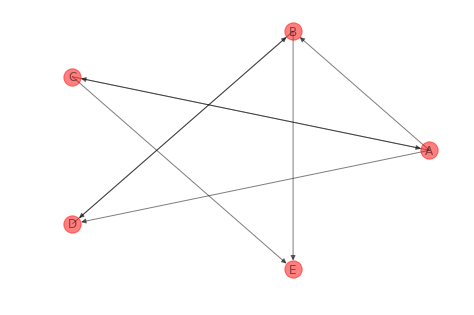

In [117]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5)

In [163]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################

TOY2_ADJ_MATR = get_adj_matr(TOY2_GRAPH)

# Node E has no outbound edges, so division by 0 occurs... Replacing value with 1 to maintain 0 values in row
row_sums = TOY2_ADJ_MATR.sum(axis=1)[:, None]
row_sums[4] = 1

transition_matrix2 = np.divide(TOY2_ADJ_MATR, row_sums)

probabilities = power_iteration(np.random.rand(transition_matrix2.shape[1]), transition_matrix2, 10, verbose=True)
print(f"Probability Sum: {np.sum(probabilities)}")

################ (END) YOUR CODE #################

Step 0:
 [0.15968885 0.89282864 0.14490591 0.27211657 0.28689951]
Step 1:
 [0.09107995 0.40898972 0.06691447 0.62809783 0.65226331]
Step 2:
 [0.04522132 0.88998193 0.04103503 0.3174335  0.32161979]
Step 3:
 [0.027932   0.45266662 0.02052104 0.62631998 0.63373094]
Step 4:
 [0.01428766 0.88510863 0.012965   0.32813162 0.32945428]
Step 5:
 [0.00905418 0.46495701 0.00665191 0.62477245 0.62717472]
Step 6:
 [0.00467933 0.88324581 0.00424614 0.33132287 0.33175605]
Step 7:
 [0.00299013 0.46883058 0.00219678 0.62417671 0.62497005]
Step 8:
 [0.00155068 0.88260358 0.00140713 0.33234854 0.33249209]
Step 9:
 [0.00099363 0.47009798 0.00073    0.62397007 0.6242337 ]
Probability Sum: 1.7200253784887816


# About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

As in previous homeworks we'll be using a 2GB subset of this data, which is available to you in this dropbox folder: 
> https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

In [118]:
# create a data directory (RUN THIS CELL AS IS)
!mkdir data

In [119]:
# download the test data set (RUN THIS CELL AS IS)
!wget -q -O data/test_graph.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AACf_33TeM7rKfEhjEoNmMCaa/PageRank-test_indexed.txt?dl=0

In [120]:
# take a look
!cat data/test_graph.txt

2	{'3': 1}
3	{'2': 1}
4	{'1': 1, '2': 1}
5	{'4': 1, '2': 1, '6': 1}
6	{'2': 1, '5': 1}
7	{'2': 1, '5': 1}
8	{'2': 1, '5': 1}
9	{'2': 1, '5': 1}
10	{'5': 1}
11	{'5': 1}


In [121]:
# download the main data set - this may take a little time (RUN THIS CELL AS IS)
!wget -O data/wiki_graph.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt?dl=0

--2019-07-13 21:49:53--  https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt?dl=0
Resolving www.dropbox.com... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt [following]
--2019-07-13 21:49:53--  https://www.dropbox.com/sh/raw/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc94e23fa6c1e298835a7a1ed46b.dl.dropboxusercontent.com/cd/0/inline/AkorhNy0B_M53_zZv-J7UDeo8tnHhtoOJyN6LAbi0hJhs18VmRkFhXF6sgirm2KK4ITrU57CVpJ578U8oqs2e3QKDk1P70KAnBcWZ_0Kb5J8yg/file# [following]
--2019-07-13 21:49:53--  https://uc94e23fa6c1e298835a7a1ed46b.dl.dropboxusercontent.com/cd/0/inline/AkorhNy0B_M53_zZ

In [122]:
# take a look (RUN THIS CELL AS IS)
!head data/wiki_graph.txt

73	{'14417532': 1}
299	{'4214575': 1}
2552	{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}
2570	{'983991': 1}
2616	{'9045350': 1}
2711	{'752887': 1}
2818	{'3534183': 1}
2847	{'3797918': 1}
2892	{'2893': 1}
2921	{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}


In [123]:
# download the indexes (RUN THIS CELL AS IS)
!wget -q -O data/indices.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AADSYhyRXbgebRDy6ALl6O1ca/wikipedia/indices.txt?dl=0

In [124]:
# take a look (RUN THIS CELL AS IS)
# You will need this file for the extra credit questions.
!head data/indices.txt

! $var = &quot;&quot;	1	1	0
! (CONFIG.SYS directive)	2	1	1
! (album)	3	12	17
! (disambiguation)	4	1	20
! -attention-	5	1	0
! Time Zone	6	1	0
!! (chess)	7	0	1
!! (disambiguation)	8	3	0
!!! (Chk Chk Chk)	9	1	0
!!! (album)	10	5	15


In [13]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
testRDD = sc.textFile('data/test_graph.txt')
indexRDD = sc.textFile('data/indices.txt')
wikiRDD = sc.textFile('data/wiki_graph.txt')

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) short response:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) code + short response:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) short response:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
> __a)__ The raw data is in TSV format.  The first value represents the wikipage ID.  The second part of each line is JSON and represents the wikipages that the current wikipage hyperlinks to and a weight value.  Moreover, this raw data appears to be an adjacency list for all of the wikipages.

> __b)__ This number represents the total number of wikipages that have outgoing hyperlinks.  There may, and likely are, wikipages that only have incoming hyperlinks without any outgoing ones which would not represented in this number.  These types of nodes I described are dangling wikipages.  

> __d)__ There are 15,192,277 - 5,781,290 = 9,410,987 dangling nodes in this wikipedia graph.


In [6]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
!wc -l data/wiki_graph.txt

5781290 data/wiki_graph.txt


In [7]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############

    def parse_line(line):
        source_node, edge_nodes = line.split('\t')
        
        yield int(source_node)
        
        for edge in ast.literal_eval(edge_nodes).keys():
            yield int(edge)
    
    totalCount = dataRDD.flatMap(parse_line).distinct().count()
    
    ############## (END) YOUR CODE ###############   
    return totalCount

In [8]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 6.7732932567596436 seconds.
Total Nodes: 11


In [9]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 397.0445325374603 seconds.
Total Nodes: 15192277


# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
 * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
 * find the average out-degree for all non-dangling nodes in the graph
 * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__ The PageRank algorithm ranks (i.e. a value between 0-1) a node more highly with each incoming edge from other nodes during the steady-state probability vector calculation.   Each node's out-degree edges are used for determining the rank of other nodes.  

> __c)__ If a node's out-degree is 0, then it means that it is a Dangling Node.  In PageRank, these types of nodes have their probability mass redistributed evenly across all other nodes when they are encountered.  This step is necessary in order to conserve the total PageRank probability mass.  

In [45]:
# part a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    ############## YOUR CODE HERE ###############

    # Parses each line and uses the values of the edge hash for determining the out-degree value
    def parse_line(line):
        source_node, edge_nodes = line.split('\t')
                
        weighted_edge_count = sum(ast.literal_eval(edge_nodes).values())
            
        yield (int(source_node), weighted_edge_count)

    # Cache RDD that will be used multiple times
    parsed_rdd = dataRDD.flatMap(parse_line).cache()
    
    # Retrieve top 10 records by out-degree count
    top = parsed_rdd.takeOrdered(10, key=lambda x: -x[1]) 
    
    # Calculate avg. out degree for non-dangling nodes
    total_out_degree = parsed_rdd.values().sum()
    out_degree_node_count = dataRDD.count()
    avgDegree = float(total_out_degree/out_degree_node_count)
   
    # Random N sample from RDD
    sampledCounts = parsed_rdd.values().takeSample(False, n)
    
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

... completed job in 0.8998534679412842 seconds
Average out-degree:  1.7
Top 10 nodes (by out-degree:)
 [(5, 3), (4, 2), (6, 2), (7, 2), (8, 2), (9, 2), (2, 1), (3, 1), (10, 1), (11, 1)]


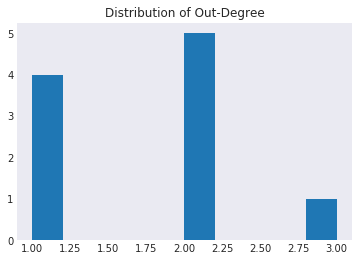

In [46]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
plt.show()

... completed job in 280.8073208332062 seconds
Average out-degree:  32.04181575392343
Top 10 nodes (by out-degree:)
 [(7804599, 9347), (7858931, 8910), (11185362, 8837), (7705822, 8142), (5760310, 7649), (7865920, 7608), (7819767, 7278), (7883280, 7231), (13035895, 7126), (7880980, 6904)]


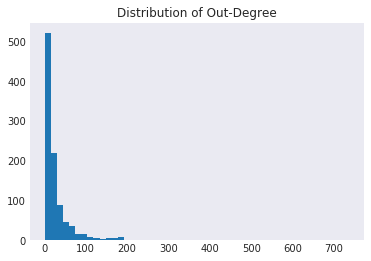

In [47]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
plt.show()

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code $N$.

### Q7 Tasks:
* __a) short response:__ What is $N$? Use the analogy of the infinite random web-surfer to explain why we'll initialize each node's rank to $\frac{1}{N}$. (i.e. what is the probabilistic interpretation of this choice?)

* __b) short response:__ Will it be more efficient to compute $N$ before initializing records for each dangling node or after? Explain your reasoning.

* __c) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __d) code:__ Run the provided code to confirm that your job in `part a` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:

> __a)__ N is the total number of nodes in the graph.  We initialize each node's rank to 1/N so that the random web-surfer initially is equally likely to visit any website in the webgraph.  More concretely in probabilistic terms, the random web-surfer has the same probability to visit any  node in the graph.  

> __b)__ It would be more efficient to compute N before initializing records for each dangling node.  Computing N before results in a Map -> Reduce -> Calculate Count -> Map to compute final probabilities while computing N afters results in a Map -> Reduce -> Map to create initial Record -> Calculate Count -> Map to add probability.  Thus, we avoid an extra Map execution by computing N before initializing the records.  

In [14]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############

    # write any helper functions here
    # Produces (node_id , (score, edges)) records
    def create_records(line):
        source_node, edges = line
        
        if len(edges) >= 1:
            # Reconstructs edge hash from custom comma-delimited string
            edge_strings = edges.split(',')
            edge_hash = {}
            for edge_weight in edge_strings:
                # Each node and its weight are seperated by a dash
                split = edge_weight.split('-')
                edge_hash[split[0]] = split[1] 

            yield (source_node, (1/node_count_b.value, edge_hash))
        
        # Output for Dangling Node
        else:
            yield (source_node, (1/node_count_b.value, {}))
            
    # Produces records with a Node ID as the Key and an edges hash as the value
    def parse_edge_hashes(line):
        source_node, edge_nodes = line.split('\t')
        
        edges = ast.literal_eval(edge_nodes)
        
        # Tried using a Hash directly, but this seemed to cause memory errors... Using a complex string object to conserve memory usage
        edge_dash = ''
        for key, value in edges.items():
            edge_dash += f"{key}-{value},"
        edge_dash = edge_dash[:-1]
            
        yield (int(source_node), edge_dash)
        
        for edge in edges.keys():
            yield (int(edge), '')
    
    # Combines 2 strings into 1 string
    def reduce_strings(x,y):
        combined = f"{x},{y}"
        
        # Removes tailing and starting commas resulting from one record being empty string
        if combined[-1] == ',':
            combined = combined[:-1]
        elif combined[0] == ',':
            combined = combined[1:]
            
        return combined
            
    # write your main Spark code here    
    
    # Create RDD with records of (SourceNodeId, EdgesHash)
    node_edges_rdd = dataRDD.flatMap(parse_edge_hashes).reduceByKey(reduce_strings).cache()

    # Count total # of nodes
    node_count = node_edges_rdd.count()
    node_count_b = sc.broadcast(node_count)

    # Compute probabilities and populate resulting RDD
    graphRDD = node_edges_rdd.flatMap(create_records)
    
    ############## (END) YOUR CODE ##############
    
    return graphRDD


In [7]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 4.697785377502441 seconds.


[(2, (0.09090909090909091, {'3': '1'})),
 (4, (0.09090909090909091, {'1': '1', '2': '1'})),
 (6, (0.09090909090909091, {'2': '1', '5': '1'})),
 (8, (0.09090909090909091, {'2': '1', '5': '1'})),
 (10, (0.09090909090909091, {'5': '1'})),
 (3, (0.09090909090909091, {'2': '1'})),
 (1, (0.09090909090909091, {})),
 (5, (0.09090909090909091, {'4': '1', '2': '1', '6': '1'})),
 (7, (0.09090909090909091, {'2': '1', '5': '1'})),
 (9, (0.09090909090909091, {'2': '1', '5': '1'})),
 (11, (0.09090909090909091, {'5': '1'}))]

In [8]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 471.0435199737549 seconds


In [9]:
# part c - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

Total number of records: 15192277
First record: [(13001625, (6.582291778908455e-08, {'8564800': '1', '5649467': '1', '9756532': '1', '498927': '1', '748494': '1', '14869807': '1', '487017': '1', '3972106': '1', '11074154': '1', '8047447': '1', '12685893': '1', '485237': '1', '9534734': '1', '498931': '1', '6958001': '1', '10642532': '1', '9545450': '1', '1212489': '1', '5138969': '1', '9590772': '1', '12846998': '1', '450158': '1', '2423708': '1', '4596477': '1', '9524795': '1', '4597689': '1', '12066216': '1', '862916': '1', '9547123': '1', '6702885': '1', '809931': '1', '476382': '1', '8886661': '1', '4774248': '1', '5283708': '3', '13348542': '1', '13443575': '1', '2029894': '1', '10642520': '2', '460416': '1', '485091': '1', '2466815': '1', '2424232': '1', '3342600': '1', '449773': '1', '13804116': '1', '446777': '1', '476363': '1', '7198313': '1', '4391712': '1', '13953489': '1', '5546448': '1', '12308892': '3', '2029885': '1', '472236': '1', '3141939': '1', '3129286': '1', '80951

# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='PR-illustrated.png'>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) short response:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$

* __b) short response:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) short response:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  * 
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

* __e)__ Please report your environment configuration. ie, # of machines, # of cores, Memory of each. As well as timings.
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ This first term refers to the teleportation probability that the walker will experience when visiting any node.  As the random walker continues to walk ad infinitum, they will always have this term chance to visit any node in the webgraph.  It represents the part of the PageRank algorithm which utilizes the Teleportation Matrix.

> __b)__ m represents the probability mass of the current visited node and is missing from the PageRank total probability mass.  We divide it by |G| so that all of the nodes will receive an equal share of the current nodes probability mass.  In short, this part of algorithm is necessary to maintain 100% total probability mass during the PageRank algorithm's execution.

> __c)__ The total probability mass after each iteration should consistently be 1.0, or 100%, to reflect that the sum of the probability for all nodes is still valid.  Any higher or lower would indicate a problem in our algorithm implementation. 

> __e)__ GCP Configuration - # of Machines: 1 Master + 2 Workers, Cores: 8 vCPU, Memory: 52GB, Time: 1hr 35min

In [15]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

#wikiGraphRDD.saveAsTextFile('wikiGraphRDDfile')
#wikiGraphRDD = sc.textFile('data/wiki_graph.txt')
from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [75]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############
    
    #reads in each record and redistributes the node's current score to each of its neighbors
    #uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (Don't forget to reset this accumulator after each iteration!)
    #uses an accumulator to keep track of the total mass being redistributed.( This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration.)
    #aggregates these partial scores for each node
    #applies telportation and damping factors as described in the formula above.
    #combine all of the above to compute the PageRank as described by the formula above.
    #WARNING: Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.
    
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions
    
    # Mapper function to convert a (node_id , (score, edges)) record into (node_id, edge_hash) and (node_id, score) records
    def disperse_mass(node_record):
        curr_node, mass_edge_tuple = node_record
        curr_mass, edge_hash = mass_edge_tuple
        
        # Add current node mass to Total Mass
        totAccum.add(float(curr_mass))
        
        edge_count = len(edge_hash.keys())
        if edge_count == 0:
            # Dangling Node - Add to mmAcum
            mmAccum.add(float(curr_mass))
        else:
            # Nondangling - Disperse mass over current edges
            # Calculation to use edge weights
            weight_sum = 0
            for val in edge_hash.values():
                weight_sum += int(val)
            partial_mass = float(curr_mass / weight_sum)

            for edge, weight in edge_hash.items():
                # Note, the test_set expected output is utilizing curr_mass instead of the weighted masses, so that is the implementation I included
                # If we wanted to use the edge weights, we would use partial_mass * int(weight) in replacement of curr_mass
                yield (int(edge), float(curr_mass / edge_count)) 
        yield (curr_node, edge_hash)
                
    # Combiner function to combine (node_id, edge_hash) and (node_id, score) records back into a (node_id , (score, edges)) record        
    def combine(grouping):
        node_id, records = grouping
        mass = 0.0
        edges = ''

        for record in records:
            if type(record) == dict:
                # Avoid updating hash by recreating and updating string
                for key, value in record.items():
                    edges += f"{key}-{value},"
            else:
                mass += float(record)

        edge_hash = {}
        if edges != '':
            # Reconstruct hash
            if edges[-1] == ',':
                edges = edges[:-1]

            for edge_weight in edges.split(','):
                # Each node and its weight are seperated by a dash
                split = edge_weight.split('-')
                edge_hash[split[0]] = split[1] 

        return (node_id, (mass, edge_hash))
    
    # Function that computes PageRank metric for each Node record
    def compute_page_rank(node_record):
        node_id, mass_tuple = node_record
        mass, edges = mass_tuple
        
        mm = mm_b.value
        node_count = count_b.value
        teleportation = a.value
        dampening = d.value
        
        page_rank = (teleportation * float(1/node_count)) + (dampening * (float(mm/node_count) + mass))
        
        return (node_id, (page_rank, edges))
    
    # Transforms (node_id , (score, edges)) records into (node_id , score) which is the expected output
    def remove_edges(node_record):
        node_id, mass_tuple = node_record
        mass = mass_tuple[0]
        return (node_id, mass)
        
            
    # write your main Spark Job here (including the for loop to iterate)
    # for reference, the master solution is 21 lines including comments & whitespace
    count_b = sc.broadcast(graphInitRDD.count())
    
    nodeMassRDD = graphInitRDD
    for i in range(1, maxIter+1): 
        # Map and Reduce
        nodeMassRDD = nodeMassRDD.flatMap(disperse_mass).groupByKey().map(combine)

        # This step is added as the action of choice per the recommendation from the FloatAccum cell to force RDD transformations to execute
        nodeMassRDD.foreach(print)

        # Broadcast missing mass for use in PageRank calculations
        mm_b = sc.broadcast(mmAccum.value)
        if verbose:
            print(f"Iteration {i} - Total Mass: {totAccum.value}, Missing Mass: {mmAccum.value}")

        # Compute PageRank
        nodeMassRDD = nodeMassRDD.map(compute_page_rank)
        
        # Reset accumulators
        mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
        totAccum = sc.accumulator(0.0, FloatAccumulatorParam())

    steadyStateRDD = nodeMassRDD.map(remove_edges)
    
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [76]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = False)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: -x[1])

...trained 20 iterations in 3.5409858226776123 seconds.
Top 20 ranked nodes:


[(2, 0.3803155224915675),
 (3, 0.3469932932917439),
 (5, 0.08088637369406641),
 (4, 0.039087602168414746),
 (6, 0.039087602168414746),
 (1, 0.032781877034008526),
 (8, 0.01616954583035677),
 (10, 0.01616954583035677),
 (7, 0.01616954583035677),
 (9, 0.01616954583035677),
 (11, 0.01616954583035677)]

__`expected results for the test graph:`__
```
(2, 0.3803155224915675)
(3, 0.3469932932917439)
(5, 0.08088637369406641)
(4, 0.039087602168414746)
(6, 0.039087602168414746)
(1, 0.032781877034008526)
(8, 0.01616954583035677)
(10, 0.01616954583035677)
(7, 0.01616954583035677)
(9, 0.01616954583035677)
(11, 0.01616954583035677)
```

In [35]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTE: wikiGraphRDD should have been computed & cached above!
if False: # See comment cell below!
    nIter = 10
    start = time.time()
    full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
    print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
    print(f'Top 20 ranked nodes:')
    full_results.takeOrdered(20, key=lambda x: -x[1])

### FROM STUDENT:  Per the highly recommended GCP approach, I have uploaded my results as an image from my GCP DataProc run for the wikiRDD
My SparkJob file is *hw5_q8.py* which is largely copy/pasted code from this notebook for Q7 and Q8.
##### HW5 Q8 Output  - Top 20 Ranked Nodes:
<img src='hw5_q8_output.PNG'>

# Extra Credit
(The combined extra credit points amount to approximately 5 percentage points on your final grade.)

## EC 1 - 5pts
The indexRDD we created earlier from the indices.txt file contains the titles of the pages and thier IDs. 

* __a)__ Join this dataset with your top 20 results.   
* __b)__ Print the results

Expected results:

<img src="joinedWithTitles.png" width="50%">

In [38]:
# part a 
joinedWithNames = None
################# YOUR CODE ##################
full_results = sc.parallelize([])

def split_tab(line):
    values = line.split('\t')
    return (values[1], values[0])

joinedWithNames = indexRDD.map(split_tab).join(full_results)
############## (END) YOUR CODE ###############

["2\t{'3': 1}", "3\t{'2': 1}", "4\t{'1': 1, '2': 1}", "5\t{'4': 1, '2': 1, '6': 1}", "6\t{'2': 1, '5': 1}"]
[('1', '! $var = &quot;&quot;'), ('2', '! (CONFIG.SYS directive)'), ('3', '! (album)'), ('4', '! (disambiguation)'), ('5', '! -attention-'), ('6', '! Time Zone'), ('7', '!! (chess)'), ('8', '!! (disambiguation)'), ('9', '!!! (Chk Chk Chk)'), ('10', '!!! (album)')]


In [ ]:
# part b
# Feel free to modify this cell to suit your implementation, but please keep the formatting and sort order.
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

## EC 2 - 30pts

GraphFrames is a graph library which is built on top of the Spark DataFrames API. 

* __a)__ Using the same dataset, run the graphframes implementation of pagerank. 
* __b)__ Join the top 20 results with indices.txt and display in the same format as above.
* __c)__ Compare your results with the results from graphframes. 

__NOTE:__ Feel free to create as many code cells as you need. Code should be clear and concise - do not include your scratch work. Comment your code if it's not self annotating.

In [39]:
# Create a GraphFrame
from graphframes import *

################# YOUR CODE ##################

vertices = sqlContext.createDataFrame(wikiRDD)
edges = sqlContext.createDataFrame(wikiRDD)
g = GraphFrame(vertices, edges)

results = g.pageRank(resetProbability=0.15, tol=0.01)
print(results.vertices)

joinedRDD = indexRDD.map(split_tab).join(results.vertices)

print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedRDD:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

############## (END) YOUR CODE ###############

ModuleNotFoundError: No module named 'graphframes'

### Congratulations, you have completed HW5! Please refer to the readme for submission instructions.